In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import warnings 
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,classification_report
from mlxtend.classifier import StackingClassifier,StackingCVClassifier
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import RandomUnderSampler

import random
import tensorflow 
import tensorflow as tf

random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def describex(data):
        data = pd.DataFrame(data)
        stats = data.describe()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        skewness_df = pd.DataFrame({'skewness':skewness}).T
        kurtosis_df = pd.DataFrame({'kurtosis':kurtosis}).T
        Appended_Stats = pd.concat([stats,skewness_df,kurtosis_df],axis=0)
        return Appended_Stats

In [3]:
def get_clf_eval(y_test,pred=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    print('Confusion Matrix')
    print(confusion)
    print('\n')
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'F1:',f1.round(3))

In [4]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props #, NAlist

In [5]:
data = pd.read_csv('melting_tank.csv').drop(['NUM'],axis=1)
data = reduce_mem_usage(data)

data = data.rename(columns={'TAG':'Target','STD_DT':'DateTime'})
data['Target'] = data['Target'].replace({'OK':0,'NG':1})

data['DateTime'] = pd.to_datetime(data['DateTime'])
data['Date'] = data['DateTime'].dt.date
data['Date'] = pd.to_datetime(data['Date'])

data['DateTime'] = data['DateTime'] + pd.TimedeltaIndex(data.groupby('DateTime').cumcount(), unit='ms')
data = data.sort_values(by='DateTime')
data = data[['Date','DateTime','MELT_TEMP','MOTORSPEED','MELT_WEIGHT','INSP','Target']]

Memory usage of properties dataframe is : 38.2325439453125  MB
******************************
Column:  MELT_TEMP
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  MOTORSPEED
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  MELT_WEIGHT
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  INSP
dtype before:  float64
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  20.7093505859375  MB
This is  54.166813005067034 % of the initial size


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         835200 non-null  datetime64[ns]
 1   DateTime     835200 non-null  datetime64[ns]
 2   MELT_TEMP    835200 non-null  uint16        
 3   MOTORSPEED   835200 non-null  uint16        
 4   MELT_WEIGHT  835200 non-null  uint16        
 5   INSP         835200 non-null  float32       
 6   Target       835200 non-null  int64         
dtypes: datetime64[ns](2), float32(1), int64(1), uint16(3)
memory usage: 27.1 MB


In [7]:
data

,Date,DateTime,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Target
0,2020-03-04,2020-03-04 00:00:00.000,489,116,631,3.19,0
1,2020-03-04,2020-03-04 00:00:00.001,433,78,609,3.19,0
2,2020-03-04,2020-03-04 00:00:00.002,464,154,608,3.19,0
3,2020-03-04,2020-03-04 00:00:00.003,379,212,606,3.19,0
4,2020-03-04,2020-03-04 00:00:00.004,798,1736,604,3.21,0
...,...,...,...,...,...,...,...
835195,2020-04-30,2020-04-30 23:59:00.005,755,1743,318,3.21,0
835196,2020-04-30,2020-04-30 23:59:00.006,385,206,317,3.19,0
835197,2020-04-30,2020-04-30 23:59:00.007,465,148,316,3.20,0
835198,2020-04-30,2020-04-30 23:59:00.008,467,0,314,3.19,0


### Sequence 재정렬 

In [8]:
df = data.drop(['Date'],axis=1)

In [9]:
df_normal = df[df['Target'] == 0]

In [10]:
df_fault = df[df['Target'] == 1]

In [11]:
df_concat = pd.concat([df_normal.iloc[:638133],df_normal.iloc[638133:648133],df_fault,df_normal.tail(10000)],axis=0)

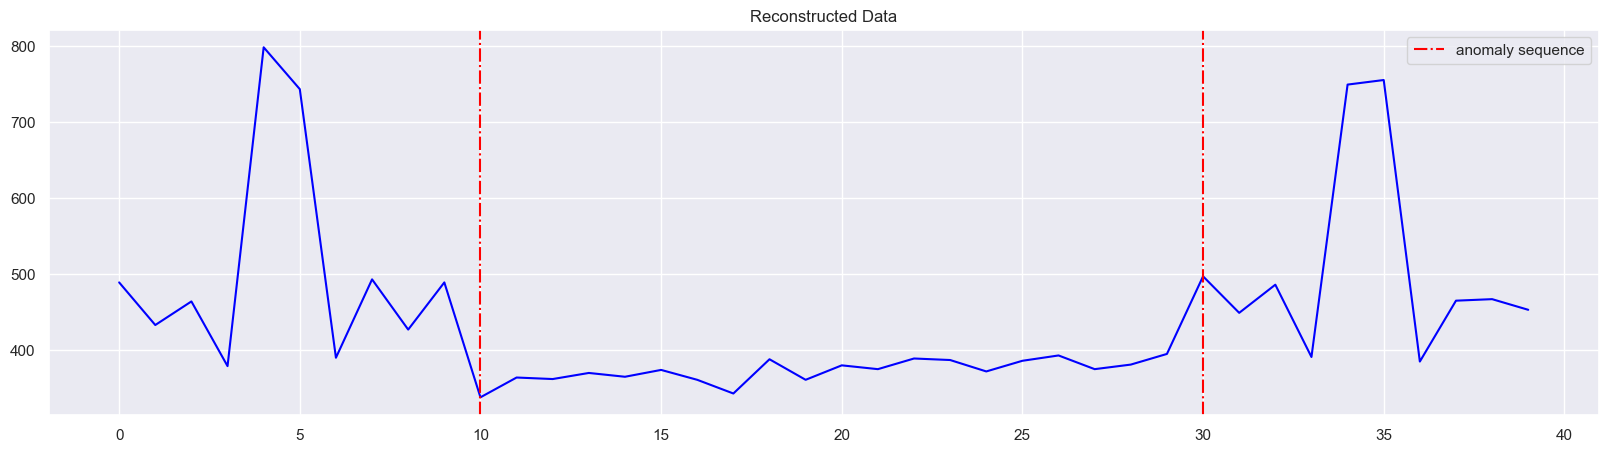

In [12]:
plt.figure(figsize=(20, 5))
sns.set(font_scale=1.0)
plt.grid(True)
plt.title('Reconstructed Data')
plt.plot(pd.concat([df_concat['MELT_TEMP'].head(10),df_fault['MELT_TEMP'].head(20),df_concat['MELT_TEMP'].tail(10)],axis=0).reset_index(drop=True),color='blue')
plt.axvline(10,linestyle='dashdot',color='red')
plt.axvline(30,linestyle='dashdot',color='red',label='anomaly sequence')
plt.legend()

#### Normal & Fault 개수 

In [13]:
len(df_concat[df_concat['Target'] == 0]),len(df_concat[df_concat['Target'] == 1])

(658133, 177067)

In [14]:
#### Test Data Normal(0) / Fault(1) 개수

In [15]:
df_concat.iloc[-197067:]['Target'].value_counts()

Target
1    177067
0     20000
Name: count, dtype: int64

In [16]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [17]:
window_size = 10
n_step_out = 1

feature = df_concat[['MELT_TEMP','MOTORSPEED','INSP','MELT_WEIGHT']]

feature_train = feature.iloc[:10000] # 동일 패턴 정상데이터 중 10000개만 선택 [ 속도 고려]
feature_val = feature.iloc[10000:11000]  # Valid 10000개 정상데이터 
feature_test = feature.iloc[-197067:]    # Test [ 정상 데이터 일부 & 불량 데이터 전체]

scaler = MinMaxScaler()
scaler.fit(feature_train)

feature_train = pd.DataFrame(scaler.transform(feature_train),columns = df_concat[['MELT_TEMP','MOTORSPEED','INSP','MELT_WEIGHT']].columns)
feature_val = pd.DataFrame(scaler.transform(feature_val),columns = df_concat[['MELT_TEMP','MOTORSPEED','INSP','MELT_WEIGHT']].columns)
feature_test = pd.DataFrame(scaler.transform(feature_test),columns = df_concat[['MELT_TEMP','MOTORSPEED','INSP','MELT_WEIGHT']].columns)

x_train,y = split_sequence(feature_train, window_size, n_step_out) 
x_val,y = split_sequence(feature_val, window_size, n_step_out) 
x_test,y = split_sequence(feature_test, window_size, n_step_out)

x_train.shape, x_val.shape, x_test.shape

((9990, 10, 4), (990, 10, 4), (197057, 10, 4))

In [18]:
#lstm_ae = Sequential()

#random.seed(1234)
#np.random.seed(1234)
#tf.random.set_seed(1234)

#lstm_ae.add(LSTM(64,activation='tanh',input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True))
#lstm_ae.add(Dropout(0.1))
#lstm_ae.add(LSTM(32,activation='tanh',return_sequences=False))

#lstm_ae.add(RepeatVector(x_train.shape[1]))

#lstm_ae.add(LSTM(32,activation='tanh',return_sequences=True))
#lstm_ae.add(Dropout(0.1))
#lstm_ae.add(LSTM(64,activation='tanh',return_sequences=True))
#lstm_ae.add(TimeDistributed(Dense(x_train.shape[2],activation='tanh')))
#lstm_ae.summary()

#lstm_ae.compile(loss='mean_squared_error',optimizer='adam',metrics='mae')
#early_stop = EarlyStopping(monitor='val_loss',patience=5)
#history = lstm_ae.fit(X_train,X_train,epochs=100,batch_size=100,validation_data=(x_val, x_val),callbacks=[early_stop])

#pred = lstm_ae.predict(x_test)

### LSTM AutoEncoder 

In [19]:
def lstm_autoencoder(X):
    
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    
    L1 = LSTM(128, activation='tanh', return_sequences=True)(inputs)
    L1 = Dropout(0.1)(L1)
    L2 = LSTM(64, activation='tanh', return_sequences=False)(L1)
    
    L3 = RepeatVector(X.shape[1])(L2)
    
    L4 = LSTM(64, activation='tanh', return_sequences=True)(L3)
    L4 = Dropout(0.1)(L4)
    L5 = LSTM(128, activation='tanh', return_sequences=True)(L4)
    
    output = TimeDistributed(Dense(X.shape[2]))(L5)   
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam',loss='mae')
    
    return model

def train_lstm_autoencoder(model,X):
    history = model.fit(X, X,batch_size = 100, epochs = 200,validation_data=(x_val, x_val),
                        callbacks=EarlyStopping(patience=5))
    
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()

    return history

Epoch 1/200
100/100 [==============================] - 11s 55ms/step - loss: 0.1495 - val_loss: 0.1304
Epoch 2/200
100/100 [==============================] - 4s 40ms/step - loss: 0.1292 - val_loss: 0.1271
Epoch 3/200
100/100 [==============================] - 4s 40ms/step - loss: 0.1264 - val_loss: 0.1247
Epoch 4/200
100/100 [==============================] - 4s 39ms/step - loss: 0.1223 - val_loss: 0.1164
Epoch 5/200
100/100 [==============================] - 4s 39ms/step - loss: 0.1157 - val_loss: 0.1119
Epoch 6/200
100/100 [==============================] - 4s 39ms/step - loss: 0.0966 - val_loss: 0.0531
Epoch 7/200
100/100 [==============================] - 4s 40ms/step - loss: 0.0464 - val_loss: 0.0370
Epoch 8/200
100/100 [==============================] - 4s 39ms/step - loss: 0.0351 - val_loss: 0.0318
Epoch 9/200
100/100 [==============================] - 4s 39ms/step - loss: 0.0310 - val_loss: 0.0283
Epoch 10/200
100/100 [==============================] - 4s 39ms/step - loss: 0.02

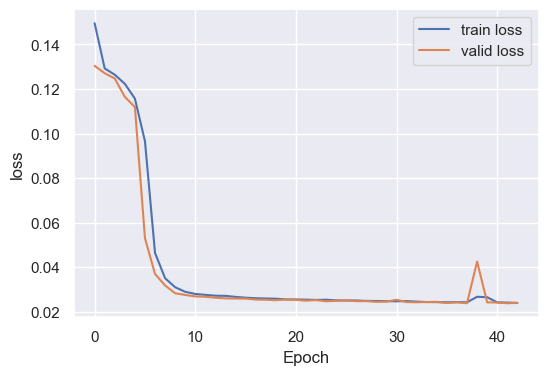

In [20]:
lstm_ae = lstm_autoencoder(x_train)

history = train_lstm_autoencoder(lstm_ae,x_train)

In [21]:
def flatten(df):
    
    flat = np.empty((df.shape[0], df.shape[2])) 
    for i in range(df.shape[0]):
        flat[i] = df[i, (df.shape[1]-1), :]

    return flat


def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(flatten(x_train_pred) - flatten(x_train)),axis=1)
    test_mae_loss = np.mean(np.abs(flatten(x_test_pred) - flatten(x_test)),axis=1)

    print('\n')
    plt.figure(figsize=(8,5))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss,color='blue', bins=40,density=True,label='Train')
    plt.hist(test_mae_loss,color='red',bins=40,density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)

    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

6159/6159 [==============================] - 43s 7ms/step




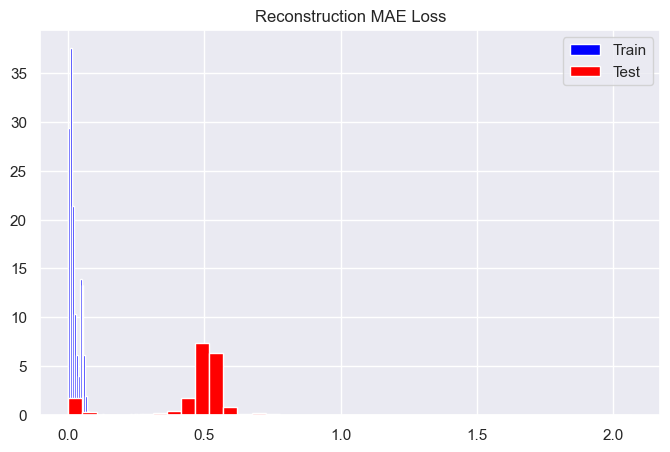



Train (Normal Only) Reconstruction error threshold: 0.27589343301951885


Test Reconstruction error threshold: 2.0699158646166325


In [22]:
train_mae_loss, test_mae_loss, threshold_train, threshold_test = reconstruction_loss(lstm_ae,x_train,x_test)

In [23]:
#plt.hist(train_mae_loss)

In [24]:
#plt.hist(test_mae_loss)

In [25]:
#threshold = 0.45
threshold = threshold_train

In [26]:
test_df = df_concat.tail(len(test_mae_loss) + window_size).iloc[window_size-1:-1]
test_df['mae_loss'] = test_mae_loss
test_df['threshold'] =  0.3 #threshold
test_df['anomaly'] = test_df['mae_loss'] >= test_df['threshold']
test_df['score'] = test_df['anomaly'].astype(int).replace({'False':0,'True':1})

In [27]:
test_df['anomaly'].value_counts()

anomaly
True     176167
False     20890
Name: count, dtype: int64

In [28]:
test_df['Target'].value_counts()

Target
1    177067
0     19990
Name: count, dtype: int64

In [29]:
print('Accuracy:',accuracy_score(test_df['Target'],test_df['score']))
print('Precision:',precision_score(test_df['Target'],test_df['score']))
print('Recall:',recall_score(test_df['Target'],test_df['score']))
print('F1-Score:',f1_score(test_df['Target'],test_df['score']))

Accuracy: 0.9953211507330366
Precision: 0.9999375592477592
Recall: 0.994855054866237
F1-Score: 0.997389832235855


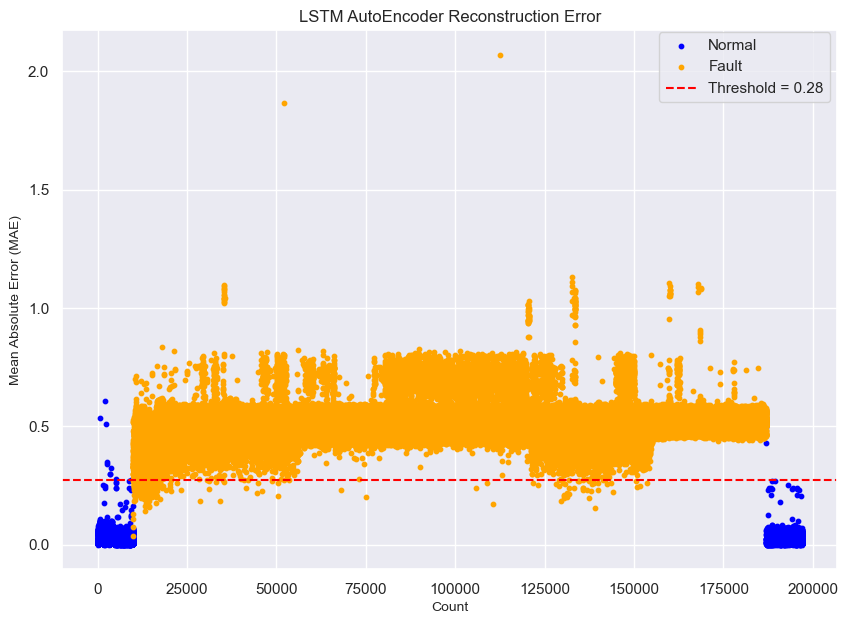

In [30]:
test_error = pd.DataFrame({'Reconstruction_error': test_mae_loss,'True_class': test_df['Target'].reset_index()['Target']})

plt.figure(figsize=(10, 7))
plt.title('LSTM AutoEncoder Reconstruction Error', fontsize=12)
plt.scatter(test_error.index[test_error['True_class'] == 0],test_error[test_error['True_class'] == 0]['Reconstruction_error'], s = 10, label = 'Normal',color='blue')
plt.scatter(test_error.index[test_error['True_class'] == 1],test_error[test_error['True_class'] == 1]['Reconstruction_error'], s = 10, label = 'Fault',color='orange')
plt.xlabel('Count', fontsize=10)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=10)
plt.axhline(threshold,color = 'red', ls = '--', label = 'Threshold = %0.2f' % (threshold))
plt.legend(bbox_to_anchor=(1.0, 1.01))
plt.show()

### Normal & Anomaly Plot

In [31]:
pred = lstm_ae.predict(x_test)

6159/6159 [==============================] - 45s 7ms/step


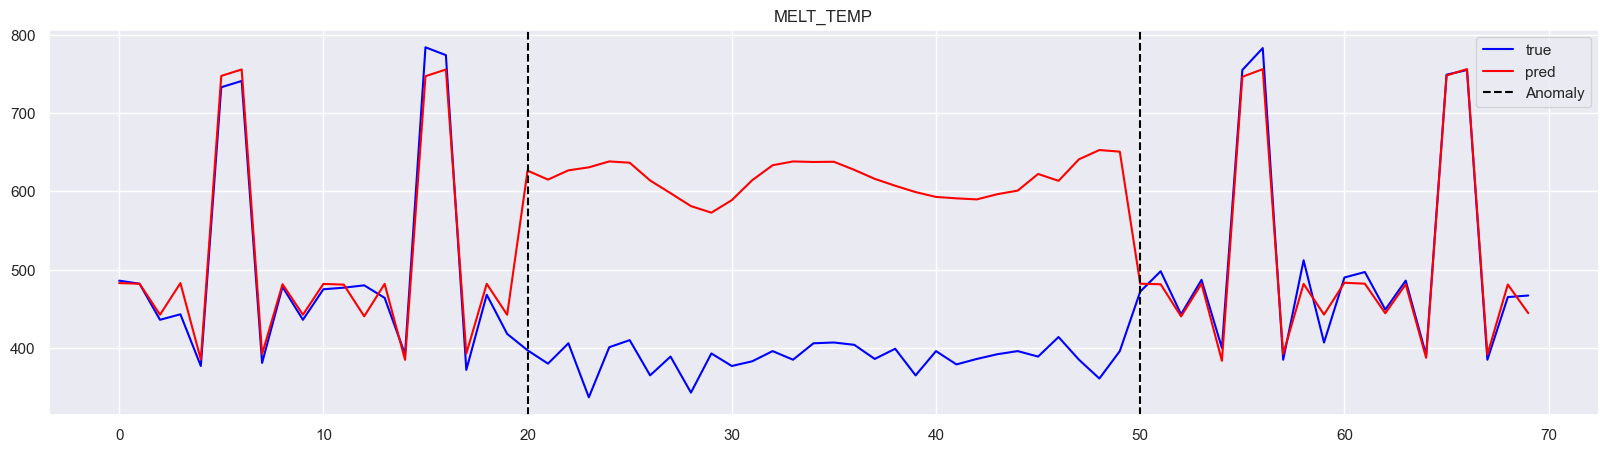

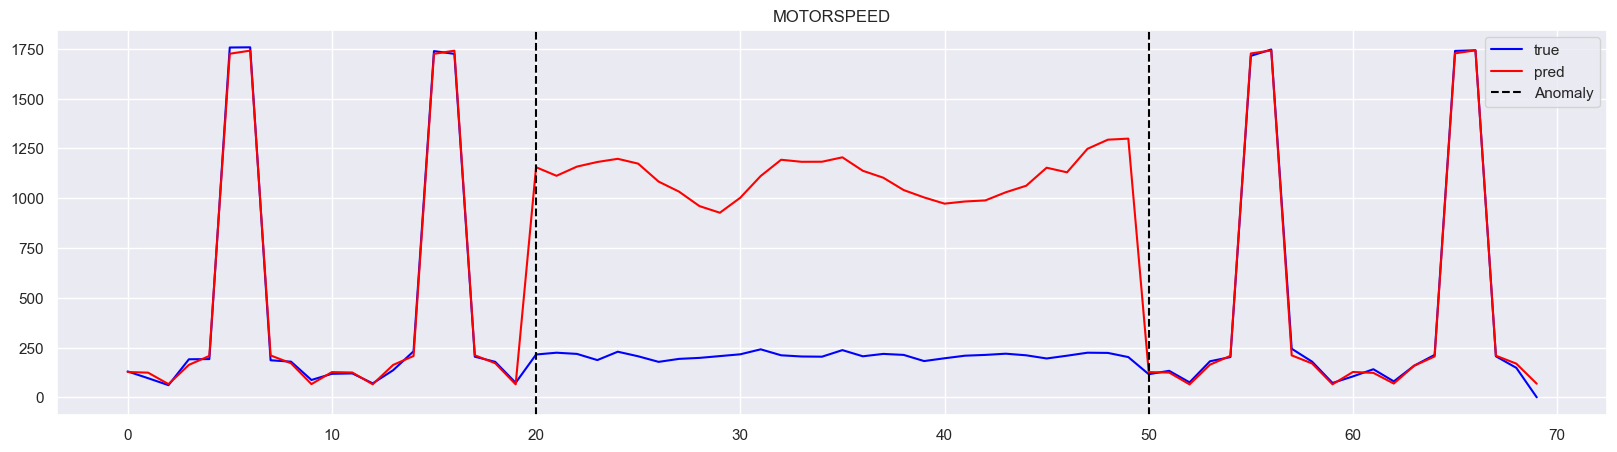

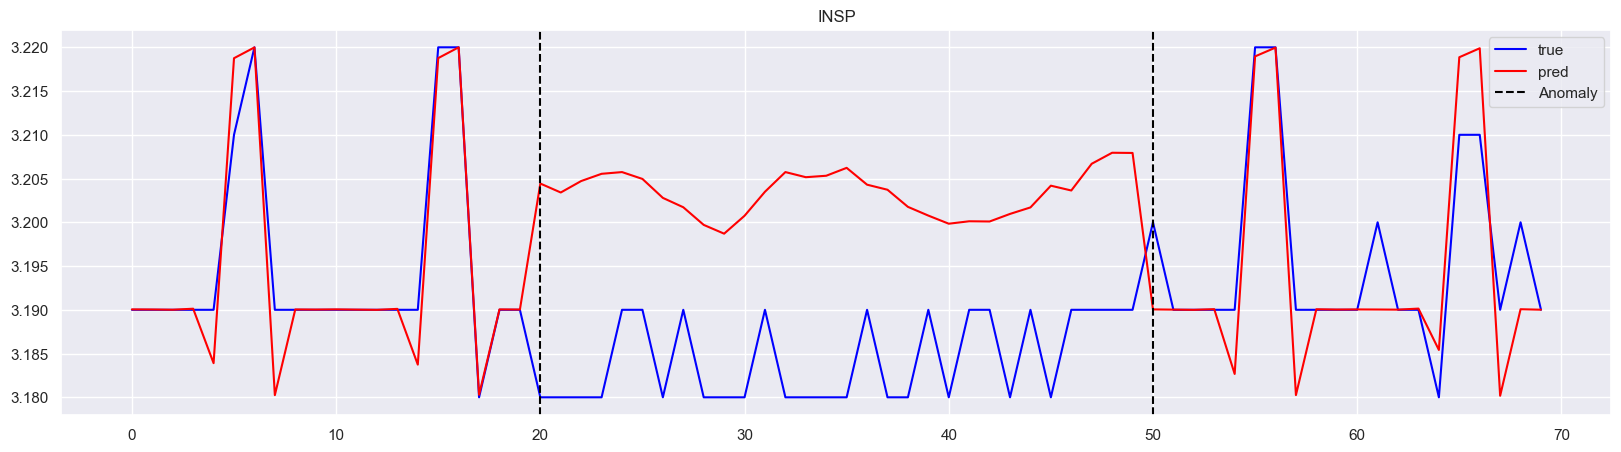

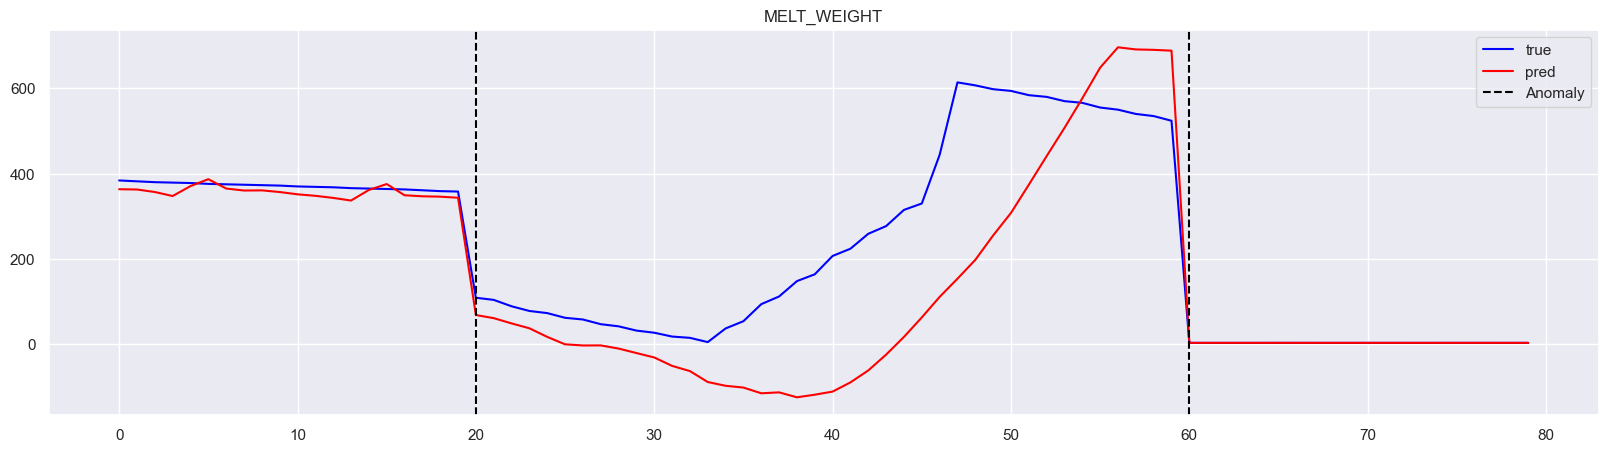

In [32]:
plt.figure(figsize=(20, 5))
plt.title('MELT_TEMP')
plt.plot(pd.concat([pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[0].head(20),pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[0].iloc[11000:11030],pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[0].tail(20)],axis=0).reset_index(drop=True),color='blue',label='true')
plt.plot(pd.concat([pd.DataFrame(scaler.inverse_transform(flatten(pred)))[0].head(20),pd.DataFrame(scaler.inverse_transform(flatten(pred)))[0].iloc[11000:11030],pd.DataFrame(scaler.inverse_transform(flatten(pred)))[0].tail(20)],axis=0).reset_index(drop=True),color='red',label='pred')
plt.axvline(x=20, color='black',linestyle='dashed',label='Anomaly')
plt.axvline(x=50, color='black',linestyle='dashed')
plt.legend()

plt.figure(figsize=(20, 5))
plt.title('MOTORSPEED')
plt.plot(pd.concat([pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[1].head(20),pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[1].iloc[11000:11030],pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[1].tail(20)],axis=0).reset_index(drop=True),color='blue',label='true')
plt.plot(pd.concat([pd.DataFrame(scaler.inverse_transform(flatten(pred)))[1].head(20),pd.DataFrame(scaler.inverse_transform(flatten(pred)))[1].iloc[11000:11030],pd.DataFrame(scaler.inverse_transform(flatten(pred)))[1].tail(20)],axis=0).reset_index(drop=True),color='red',label='pred')
plt.axvline(x=20, color='black',linestyle='dashed',label='Anomaly')
plt.axvline(x=50, color='black',linestyle='dashed')
plt.legend()

plt.figure(figsize=(20, 5))
plt.title('INSP')
plt.plot(pd.concat([pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[2].head(20),pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[2].iloc[11000:11030],pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[2].tail(20)],axis=0).reset_index(drop=True),color='blue',label='true')
plt.plot(pd.concat([pd.DataFrame(scaler.inverse_transform(flatten(pred)))[2].head(20),pd.DataFrame(scaler.inverse_transform(flatten(pred)))[2].iloc[11000:11030],pd.DataFrame(scaler.inverse_transform(flatten(pred)))[2].tail(20)],axis=0).reset_index(drop=True),color='red',label='pred')
plt.axvline(x=20, color='black',linestyle='dashed',label='Anomaly')
plt.axvline(x=50, color='black',linestyle='dashed')
plt.legend()

plt.figure(figsize=(20, 5))
plt.title('MELT_WEIGHT')
plt.plot(pd.concat([pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[3].head(20),pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[3].iloc[11000:11040],pd.DataFrame(scaler.inverse_transform(flatten(x_test)))[2].tail(20)],axis=0).reset_index(drop=True),color='blue',label='true')
plt.plot(pd.concat([pd.DataFrame(scaler.inverse_transform(flatten(pred)))[3].head(20),pd.DataFrame(scaler.inverse_transform(flatten(pred)))[3].iloc[11000:11040],pd.DataFrame(scaler.inverse_transform(flatten(pred)))[2].tail(20)],axis=0).reset_index(drop=True),color='red',label='pred')
plt.axvline(x=20, color='black',linestyle='dashed',label='Anomaly')
plt.axvline(x=60, color='black',linestyle='dashed')
plt.legend()

### Feature Importance 

In [33]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32) # TensorShape([18057, 10, 4]) 3차원 텐서 변환. / 입력값 X 정의

    with tf.GradientTape() as tape: # Y = aX 식 정의 
        predictions = model(seq) # predictions -> Y / seq --> X 

    grad = tape.gradient(predictions, seq) # dy/dx 정의. X에 대한 Y의 변화. 입력값에 대한 출력값의 변화. Time Step별 기울기
    grad = tf.reduce_mean(grad, axis=1).numpy()[0] # Time Step별 미분계수 평균
    
    return grad # 결과 출력

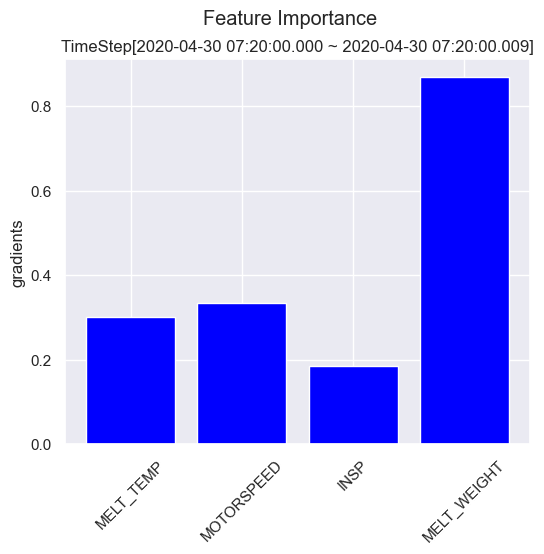

In [34]:
grad_imp = gradient_importance(x_test[0],lstm_ae) # 편미분계수 크기 (기울기 크기 )

plt.figure(figsize=(6,5))
plt.bar(range(len(grad_imp)),  np.abs(grad_imp),color='blue')
plt.xticks(range(len(feature.columns)), feature.columns, rotation=45)
plt.ylabel('gradients')
plt.title('TimeStep[2020-04-30 07:20:00.000 ~ 2020-04-30 07:20:00.009]')
plt.suptitle('Feature Importance')
plt.show()

In [35]:
#def timeseries_reconstruction(timestep):
    
#    plt.figure(figsize=(15, 2))
#    plt.title('MELT_TEMP')
#    plt.plot(pd.DataFrame(x_test[timestep])[0],color='blue',label='Test Data')
#    plt.plot(pd.DataFrame(pred[timestep])[0],color='red',label='Prediction')
#    plt.legend()

#    plt.figure(figsize=(15, 2))
#    plt.title('MOTORSPEED')
#    plt.plot(pd.DataFrame(x_test[timestep])[1],color='blue',label='Test Data')
#    plt.plot(pd.DataFrame(pred[timestep])[1],color='red',label='Prediction')
#    plt.legend()
    
#    plt.figure(figsize=(15, 2))
#    plt.title('INSP')
#    plt.plot(pd.DataFrame(x_test[timestep])[2],color='blue',label='Test Data')
#    plt.plot(pd.DataFrame(pred[timestep])[2],color='red',label='Prediction')
#    plt.legend()
    
#    plt.figure(figsize=(15, 2))
#    plt.title('MELT_WEIGHT')
#    plt.plot(pd.DataFrame(x_test[timestep])[3],color='blue',label='Test Data')
#    plt.plot(pd.DataFrame(pred[timestep])[3],color='red',label='Prediction')
#    plt.legend()
    
#for timestep in range(0,x_test.shape[0]):
#    timeseries_reconstruction(timestep)
#timeseries_reconstruction(timestep=0)  